In [1]:
%load_ext autoreload
%autoreload 2
    
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
mpl.rcParams['pdf.fonttype'] = 42

2024-11-04 12:52:44 - INFO - Failed to extract font properties from /usr/share/fonts/google-noto-emoji/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
/home/rzhang/miniforge3/envs/depmap/lib/python3.10/site-packages/scprinter/seq/interpretation/attributions.py:73: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(params, nopython=False)


In [2]:
def strided_axis0(a, L):
    # Store the shape and strides info
    shp = a.shape
    s  = a.strides

    # Compute length of output array along the first axis
    nd0 = shp[0]-L+1

    # Setup shape and strides for use with np.lib.stride_tricks.as_strided
    # and get (n+1) dim output array
    shp_in = (nd0,L)+shp[1:]
    strd_in = (s[0],) + s
    return np.lib.stride_tricks.as_strided(a, shape=shp_in, strides=strd_in)


In [6]:
paths = [
    '../PRINT_rev/BMMC/final_model/BMMC_lora_fold0-azure-meadow-7.pt',
    '../PRINT_rev/BMMC/final_model/BMMC_lora_fold1-usual-feather-4.pt',
    '../PRINT_rev/BMMC/final_model/BMMC_lora_fold2-quiet-energy-21.pt',
    '../PRINT_rev/BMMC/final_model/BMMC_lora_fold3-snowy-lion-1.pt',
    '../PRINT_rev/BMMC/final_model/BMMC_lora_fold4-solar-frost-8.pt',
]
# shared info to load
barcodegroups = pd.read_table('/data/rzhang/PRINT_rev/BMMC/barcodeGrouping.txt.gz')
groupinfo = pd.read_table("/data/rzhang/PRINT_rev/BMMC/groupInfo.txt")
CREs = pd.read_csv('/data/rzhang/PRINT_rev/BMMC/peaks_annotation.tsv', sep='\t')
CREs['start'] = CREs['start'] - 1

In [7]:
ct2color = {}
colors = []
cts = list(groupinfo['cellType'].unique())
for ct in cts:
    tp = groupinfo[groupinfo['cellType'] == ct]
    ct = ct.replace('/', '_')
    color = tp['color'].unique()
    ct2color[ct] = color[0]
    colors.append(color[0])

In [10]:
from tqdm.auto import *
import pyBigWig
CREs = pd.read_csv('/data/rzhang/PRINT_rev/BMMC/peaks_annotation.tsv', sep='\t')
CREs['start'] = CREs['start'] - 1
cts = list(groupinfo['cellType'].unique())

def fetch_one(ct):
    signals = []
    bw = f'/data/rzhang/PRINT_rev/BMMC/final_model/tfbs/{ct}_lora_TFBS.bigwig'
    with pyBigWig.open(bw, 'r') as f:
        chrom = np.array(CREs['seqnames'])
        starts, ends = np.array(CREs['start']), np.array(CREs['end'])    
        for c, start,end in zip(tqdm(chrom, disable=True), starts, ends):
            v = f.values(c, start, end, numpy=True)
            # v = np.nanmean(v)
            
            signals.append(v)
    signals = np.array(signals)
    signals = np.nan_to_num(signals)
    return signals

new_cts = []
for ct in cts:
    ct = ct.replace('/', '_')
    new_cts.append(ct)
results = np.array(process_map(fetch_one, new_cts, max_workers=20))

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
shapes = results.shape
subcCRE_signals = results.reshape((shapes[0], shapes[1], -1, 10))
subcCRE_signals = subcCRE_signals.mean(axis=-1)
subcCRE_signals.shape

(20, 189259, 100)

In [12]:
import os
# os.environ['JOBLIB_START_METHOD'] = 'forkserver'
# os.environ['OMP_NUM_THREADS'] = '2'
# from threadpoolctl import threadpool_limits
# from joblib import parallel_backend

from sklearn.decomposition import *
    
def process_one(group_id):
    # Use parallel_backend to limit the number of cores for cross_val_score
    # Limit the number of threads
    xxx = smoothed_res[:, group_id, :].T
    thres_min = np.mean(xxx) + np.std(xxx) * 2
    mask = np.quantile(xxx, 0.95, axis=-1) > max(0.2, thres_min)
    # vb = np.sum(mask)
    vb = [np.sum(mask), np.mean(xxx), np.std(xxx)]
    # print (thres_min, vb)
    # valid_bin = np.sum(np.quantile(xxx, 0.9, axis=-1) <= thres_min)
    if vb[0] < 50:
        # groups.append(0)
        return vb, np.array([1]+[0]*9)
    yyy = np.copy(xxx)
    
    # vbs.append([np.mean(xxx.reshape((-1))), np.std(xxx.reshape((-1)))])
    # yyy[np.quantile(xxx, 0.9, axis=-1) <= thres_min] = 0.0
    # yyy = xxx[mask]
    # yyy = yyy / np.mean(yyy, axis=-1, keepdims=True)
    # corr_mtx = np.corrcoef(xxx)
    # corrs.append(np.corrcoef(xxx.T))

    model = PCA(n_components=10)
    pcs = model.fit_transform(yyy)
    # pcs = normalize(pcs, axis=1)
    # print (np.cumsum(model.explained_variance_ratio_))
    # i = np.where(np.cumsum(model.explained_variance_ratio_) > 0.9)[0][0] + 1
    return vb, model.explained_variance_ratio_
    

In [13]:
def strided_lastaxis(a, L):
    pad_vec1 = np.stack([a[..., 0]] * (L // 2), axis=-1)
    pad_vec2 = np.stack([a[..., -1]] * (L // 2), axis=-1)
    a = np.concatenate([pad_vec1, a, pad_vec2], axis=-1)
    s0, s1, s2 = a.strides
    l, m, n = a.shape
    return np.lib.stride_tricks.as_strided(a, shape=(l, m, n - L + 1, L), strides=(s0, s1, s2, s2))

smoothed_res = strided_lastaxis(results, 5).mean(axis=-1)[..., :results.shape[-1]]
print (smoothed_res.shape)

(20, 189259, 1000)


In [14]:
from sklearn.preprocessing import normalize
from scipy.stats import *
import scanpy as sc
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as spd
from sklearn.decomposition import PCA

results = [process_one(x) for x in trange(smoothed_res.shape[1])]
# results = process_map(process_one, np.arange(smoothed_res.shape[1]), max_workers=64, chunksize=10)
pc_info = np.array([x[1] for x in results])
vbs = np.array([x[0] for x in results])
if len(vbs.shape) == 1:
    vbs = vbs[:, None]

  0%|          | 0/189259 [00:00<?, ?it/s]

In [15]:
from sklearn.linear_model import *
pc_info_regress = np.copy(pc_info)
regress_mask = pc_info_regress[:, 0] < 1
to_learn = np.log(vbs[regress_mask][:, :])
pc_info_regress[regress_mask] = pc_info[regress_mask] - LinearRegression(fit_intercept=True).fit(to_learn, 
                                                                                                 pc_info[regress_mask]).predict(to_learn) + pc_info[regress_mask].mean(axis=0, keepdims=True)
pc_info_regress[pc_info_regress < 0] = 0
pc_info_regress = pc_info

In [16]:
pc_info_regress = pc_info_regress / np.sum(pc_info_regress, axis=-1, keepdims=True)
pc_info_regress = np.cumsum(pc_info_regress, axis=-1)


In [17]:
groups = []
for pc in pc_info_regress:
    groups.append(np.where(pc > 0.98)[0][0] + 1 if pc[0] < 1 else 0)


(189259, 0.5025236038569707, 109611)

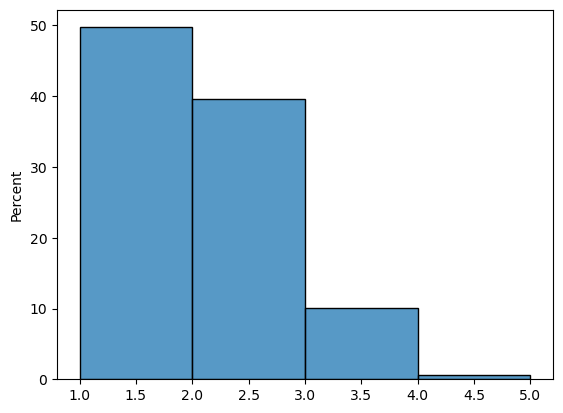

In [18]:
groups = np.array(groups)
sns.histplot(groups[groups > 0], binwidth=1, stat='percent')
# plt.savefig('/data/rzhang/PRINT_rev/BMMC/groups.pdf')
len(groups), np.sum(groups >= 2) / np.sum(groups > 0), np.sum(groups == 0)

In [20]:
CREs

,seqnames,start,end,width,strand,feature
1,chr1,9836,10836,1000,*,Intergenic
2,chr1,28860,29860,1000,*,promoter-TSS (NR_024540)
3,chr1,181070,182070,1000,*,promoter-TSS (NR_148357)
4,chr1,191078,192078,1000,*,Intergenic
5,chr1,267519,268519,1000,*,Intergenic
...,...,...,...,...,...,...
189255,chrX,155577367,155578367,1000,*,"intron (NM_018196, intron 1 of 7)"
189256,chrX,155611181,155612181,1000,*,promoter-TSS (NM_001304990)
189257,chrX,155612352,155613352,1000,*,promoter-TSS (NM_001184797)
189258,chrX,155632170,155633170,1000,*,"intron (NM_001304990, intron 1 of 2)"


In [24]:
import anndata
peak_adata = anndata.read_h5ad('/data/rzhang/PRINT_rev/BMMC/peak_matrix.h5ad')
from scprinter.chromvar import *
import time
start = time.time()
sample_bg_peaks(peak_adata, scp.genome.hg38,
                method='nndescent', # method='chromvar' do the whole binning and sampling thing (faster), when it's 'nndescent' it'll just fit a knn directory on peaks (which is also pretty fast)
                niterations=250)
motifs = scp.motifs.FigR_Human_Motifs(
                           scp.genome.hg38, 
                           list(peak_adata.uns['bg_freq']),
                           n_jobs=32,pvalue=5e-5, 
                           mode='motifmatchr' # when turn on mode='motifmatchr', it replicates the behavior and results of motifmatchr
                          )
motifs.prep_scanner(tf_genes=None,pvalue=5e-5)
motifs.chromvar_scan(peak_adata)
print ("takes", time.time()-start)

names = peak_adata.uns['motif_name']
names = np.array(names)
names = np.where(names == 'CTCF')
select = peak_adata.varm['motif_match'][:, names]
select = np.array(select).reshape((-1)).astype('bool')
select

ctcfs = select #['CTCF' if xx else '' for xx in select]
CREs['promoter'] = [xx.split(" ")[0] == 'promoter-TSS' for xx in CREs['feature']]
CREs['ctcf'] = ctcfs
CREs

  0%|          | 0/378518 [00:00<?, ?it/s]

takes 847.9549775123596


,seqnames,start,end,width,strand,feature,promoter,ctcf
1,chr1,9836,10836,1000,*,Intergenic,False,False
2,chr1,28860,29860,1000,*,promoter-TSS (NR_024540),True,False
3,chr1,181070,182070,1000,*,promoter-TSS (NR_148357),True,True
4,chr1,191078,192078,1000,*,Intergenic,False,True
5,chr1,267519,268519,1000,*,Intergenic,False,True
...,...,...,...,...,...,...,...,...
189255,chrX,155577367,155578367,1000,*,"intron (NM_018196, intron 1 of 7)",False,False
189256,chrX,155611181,155612181,1000,*,promoter-TSS (NM_001304990),True,True
189257,chrX,155612352,155613352,1000,*,promoter-TSS (NM_001184797),True,False
189258,chrX,155632170,155633170,1000,*,"intron (NM_001304990, intron 1 of 2)",False,False


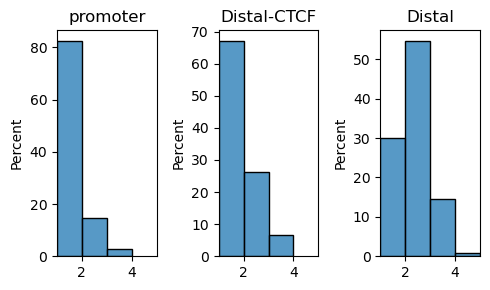

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(5,3))
g = groups[CREs['promoter']]
g = g[g > 0]
sns.histplot(g, binwidth=1, label=t,stat='percent', ax=axs[0])
axs[0].set_title('promoter')
axs[0].set_xlim(1, 5)

g = groups[(~CREs['promoter']) & (CREs['ctcf'])]
g = g[g > 0]
sns.histplot(g, binwidth=1, label=t,stat='percent', ax=axs[1])
axs[1].set_title('Distal-CTCF')
axs[1].set_xlim(1, 5)
g = groups[(~CREs['promoter']) & (~CREs['ctcf'])]
g = g[g > 0]
sns.histplot(g, binwidth=1, label=t,stat='percent', ax=axs[2])
axs[2].set_title('Distal')
axs[2].set_xlim(1, 5)

plt.tight_layout()
# plt.savefig('/data/rzhang/PRINT_rev/BMMC/CREs_groups.pdf')
# plt.legend()